In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
               
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 days 19 hours 7 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_josephdown_bis3r7
H2O cluster total nodes:,1
H2O cluster free memory:,3.424 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [85]:
fy_10 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy10-operating-budget.xlsx")
fy_11 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy11-operating-budget.xlsx")
fy_12 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy12-operating-budget.xlsx")
fy_13 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy13-operating-budget.xlsx")
fy_14 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy14-operating-budget.xlsx")
fy_15 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy15-operating-budget.xlsx")
fy_16 = pd.read_excel("fy16-budget-vs-actuals-revenue-and-expenses.xls")

#Clean up the formating of FY16
fy_16.columns = fy_16.loc[0].values
fy_16 = fy_16.loc[1:]

In [86]:
fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

for year in fy_list:
    year['OA_Difference'] = year['Actuals']-year['Original Budget']
    year = year.loc[year['Revenue or Expenditure']=="Expenditures"]
    year.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
len(fy_list)

7

In [88]:
df = pd.concat(fy_list)
df.dropna(inplace=True)

houston_data = pd.read_csv("Houston Yearly Data - Sheet1 (1).csv")
houston_data_columns = houston_data.iloc[1,1:].values
houston_data_index = houston_data.iloc[2:,0].values
houston_data  = houston_data.iloc[2:,1:]


In [89]:
houston_data.index= houston_data_index
houston_data.columns = houston_data_columns
houston_data.columns = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019']
houston_data.fillna(0, inplace=True)
houston_data['2019'] = houston_data['2019'].astype(int)



# sum_ = 0
# for column in categorical_variables:
#     print(column, len(df[column].value_counts()))
#     sum_ += len(df[column].value_counts())
# print(sum_)

In [90]:
categorical_variables = ['Fund Name', 'Fund Type Descr', 'Business Area Name','Commitment Set Description']

#dummies = pd.get_dummies(df[categorical_variables]) # One-hot encoding of categorical variables
#df = pd.concat([dummies, df.drop(categorical_variables, axis=1)], axis=1)


In [91]:
def add_houston_data(year_df, houston_data, houston_data_index):
    for col in houston_data_index:
        year_df[col] = 0
    
    budget_year = year_df.iloc[0]['Fiscal Year']
    previous_year =  year_df.iloc[0]['Fiscal Year'] - 1
    
    year_df['Rockets Playoff Rounds'] = float(houston_data[str(previous_year)]['Rockets Playoff Rounds'].replace(',',''))
    year_df['Rockets Total Attendance'] = float(houston_data[str(previous_year)]['Rockets Total Attendance'].replace(',',''))
    year_df['Texans Average Attendance'] = float(houston_data[str(budget_year)]['Texans Average Attendance'].replace(',',''))
    year_df['Texans Playoff Rounds'] = float(houston_data[str(budget_year)]['Texans Playoff Rounds'].replace(',',''))
    year_df['Astros Yearly Attendance'] = float(houston_data[str(previous_year)]['Astros Yearly Attendance'].replace(',',''))
    year_df['Astros Playoff Rounds'] = float(houston_data[str(previous_year)]['Astros Playoff Rounds'].replace(',',''))

    year_df['Yearly Crime Index'] = float(houston_data[str(previous_year)]['Yearly Crime Index'].replace(',',''))
    year_df['Yearly Avg High Temp'] = float(houston_data[str(previous_year)]['Yearly Avg High Temp'].replace(',',''))
    year_df['Yearly Avg Low Temp'] = float(houston_data[str(previous_year)]['Yearly Avg Low Temp'].replace(',',''))
    year_df['Yearly Rain Fall'] = float(houston_data[str(previous_year)]['Yearly Rain Fall'].replace(',',''))
    
    return year_df

In [92]:
for year_index, year in enumerate(fy_list):
    dummies = pd.get_dummies(year[categorical_variables]) # One-hot encoding of categorical variables
    year = pd.concat([dummies, year.drop(categorical_variables, axis=1)], axis=1)
    year.drop('Fund Center Name', axis=1, inplace=True) #This is repeated information
    fy_list[year_index] = add_houston_data(year, houston_data, houston_data_index)

In [96]:
shared_columns = list(set(fy_list[0].columns) & set(fy_list[1].columns) & set(fy_list[2].columns) & 
             set(fy_list[3].columns) & set(fy_list[4].columns) & set(fy_list[5].columns) & 
             set(fy_list[6].columns))

for year_index, year in enumerate(fy_list):
    drop_columns = list(set(shared_columns).symmetric_difference(set(fy_list[year_index].columns)))
    fy_list[year_index].drop(drop_columns, axis=1, inplace=True)
    
    

In [101]:
fy_list[6]['Fiscal Year'] = fy_list[6]['Fiscal Year'].astype(int)
fy_list[3]['Original Budget'] = fy_list[3]['Original Budget'].astype(float)
fy_list[4]['Original Budget'] = fy_list[4]['Original Budget'].astype(float)
fy_list[5]['Original Budget'] = fy_list[5]['Original Budget'].astype(float)
# fy_1ist[4]['Original Budget'] = fy_list[4]['Original Budget'].astype(float)
# fy_list[5]['Original Budget'] = fy_list[5]['Original Budget'].astype(float)

In [103]:
data_types_df = pd.DataFrame()
for index, item in enumerate(fy_list):
    if index==0:
        data_types_df['Column'] = fy_list[index].dtypes.index
    data_types_df['201'+ str(index) +'_'] = fy_list[index].dtypes.values

In [112]:
data_types_df.iloc[:,:7]

,Column,2010_,2011_,2012_,2013_,2014_,2015_
0,Fund Name_Asset Forfeiture Fund - Justice,uint8,uint8,uint8,uint8,uint8,uint8
1,Fund Name_Asset Forfeiture Fund - State,uint8,uint8,uint8,uint8,uint8,uint8
2,Fund Name_Asset Forfeiture Fund - Treasury,uint8,uint8,uint8,uint8,uint8,uint8
3,Fund Name_Auto Dealers Fund,uint8,uint8,uint8,uint8,uint8,uint8
4,Fund Name_Building Inspection Fund,uint8,uint8,uint8,uint8,uint8,uint8
5,Fund Name_C&E-Civic Center Facility Revenue Fund,uint8,uint8,uint8,uint8,uint8,uint8
6,Fund Name_Cable Television Fund,uint8,uint8,uint8,uint8,uint8,uint8
7,Fund Name_Child Safety Fund,uint8,uint8,uint8,uint8,uint8,uint8
8,Fund Name_Digital Houston Special Revenue,uint8,uint8,uint8,uint8,uint8,uint8
9,Fund Name_Expansion of Recycling Program,uint8,uint8,uint8,uint8,uint8,uint8


In [126]:
drop_list = ['GL Description','GL Category Description','Revenue or Expenditure']


In [135]:
train_list = [fy_list[0], fy_list[1], fy_list[2], fy_list[3]]
test_list = [fy_list[4], fy_list[5]]

X_train = pd.concat(train_list).drop(['OA_Difference','Actuals','Current Budget'], axis=1)
X_test = pd.concat(test_list).drop(['OA_Difference', 'Actuals', 'Current Budget'], axis = 1)
y_train = pd.concat(train_list)['OA_Difference']
y_test = pd.concat(test_list)['OA_Difference']


In [124]:
# X_test.drop(drop_list, axis=1, inplace=True)
# X_train.drop(drop_list, axis=1, inplace=True)

In [51]:
# for col in numerical:
#     X_test[col]=X_test[col].astype(float)

In [ ]:
# X_train.drop(object_list, axis=1, inplace= True)
# X_test.drop(object_list, axis=1, inplace=True)

#X_train.drop(['GL Description','Original Budget'], axis=1, inplace= True)
#X_test.drop(['GL Description','Original Budget'], axis=1, inplace= True)

In [128]:
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
print (model)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:44:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


In [129]:
xgb_test_predictions = model.predict(X_test)
xgb_train_predictions = model.predict(X_train)

In [130]:
np.sqrt(np.mean((xgb_test_predictions-y_test)**2))


1345973.4688112203

Text(0, 0.5, 'predictions')

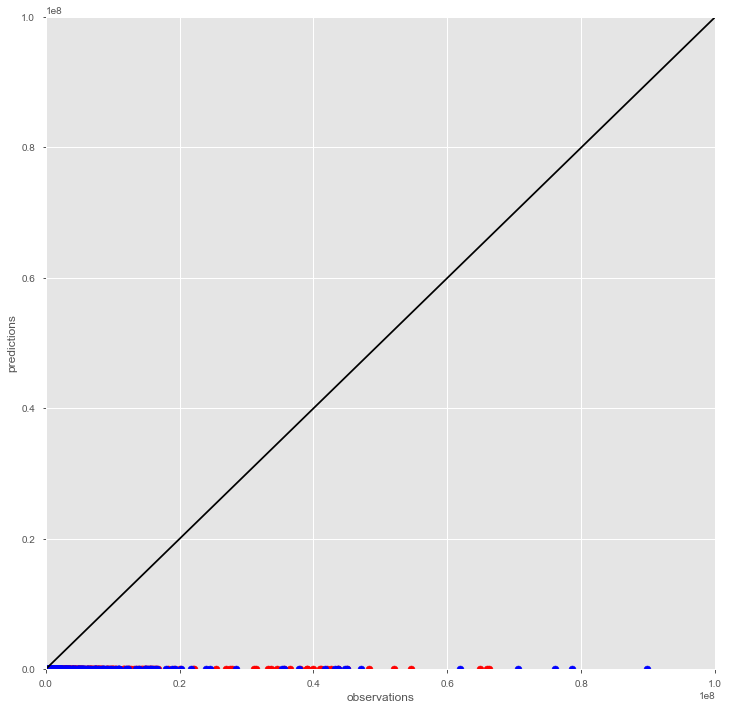

In [131]:
x = np.linspace(-100000000,100000000,100000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, xgb_train_predictions, c='red')
plt.scatter(y_test, xgb_test_predictions, c='blue')
#plt.scatter(train_df['voyage_duration'], train_df['eta_diff'], c='green')
plt.plot(x,x,c='black')
plt.xlim([-5,100000000])
plt.ylim([-5,100000000])
plt.xlabel('observations')
plt.ylabel('predictions')

In [ ]:
fy_name_list = ['fy_10', 'fy_11', 'fy_12', 'fy_13', 'fy_14', 'fy_15', 'fy_16']

for index, year in enmerate(fy_list):
    pd.to_csv(year, (fy_name_list[index] + fy_name_list[index]))

# H2o

In [136]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['OA_Difference']
training_frame = h2o.H2OFrame(training_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [137]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['OA_Difference']
testing_frame = h2o.H2OFrame(testing_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [138]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'OA_Difference', training_frame)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [139]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))


Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'GL Description' has levels not trained on: [411080 - Prior Year Delinquent Property Tax 1995, 411178 - Prior Year Delinquent Property Tax - 201, 411179 - Prior Year Delinquent Property Tax - 201, 421090 - Ambulance Permits, 421235 - TNC Permits & Licenses, 424210 - Interfund Radio Parts & Labor, 424215 - Interfund Radio System Access, 425120 - Indirect Cost Recovery - PWE, 426470 - WIFI Revenues, 426510 - Environmental Lab Services, 426520 - External Radio System Access Fees, 427290 - Truancy Prevention and Diversion Revenue, 435110 - Public Improvement District Assessment, 447021 - Hobby Garage Parking Revenue, 447022 - Metro Passes Revenue, 451000 - Escrow Deposit - Bond refunding, 452040 - Payment in Lieu of Taxes, 456176 - Recycling Revenues, 500045 - Patrol Incentive Pay, 520117 - Security Equipment Services, 520149 - Internship Program, 520739 - Ambulance Refund, 520757 - Maintenanc

1721273.0930836922

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'GL Description' has levels not trained on: [411080 - Prior Year Delinquent Property Tax 1995, 411178 - Prior Year Delinquent Property Tax - 201, 411179 - Prior Year Delinquent Property Tax - 201, 421090 - Ambulance Permits, 421235 - TNC Permits & Licenses, 424210 - Interfund Radio Parts & Labor, 424215 - Interfund Radio System Access, 425120 - Indirect Cost Recovery - PWE, 426470 - WIFI Revenues, 426510 - Environmental Lab Services, 426520 - External Radio System Access Fees, 427290 - Truancy Prevention and Diversion Revenue, 435110 - Public Improvement District Assessment, 447021 - Hobby Garage Parking Revenue, 447022 - Metro Passes Revenue, 451000 - Escrow Deposit - Bond refunding, 452040 - Payment in Lieu of Taxes, 456176 - Recycling Revenues, 500045 - Patrol Incentive Pay, 520117 - Security Equipment Services, 520149 - Internship Program, 520739 - Ambulance Refund, 520757 - Maintenanc

Text(0, 0.5, 'predictions')

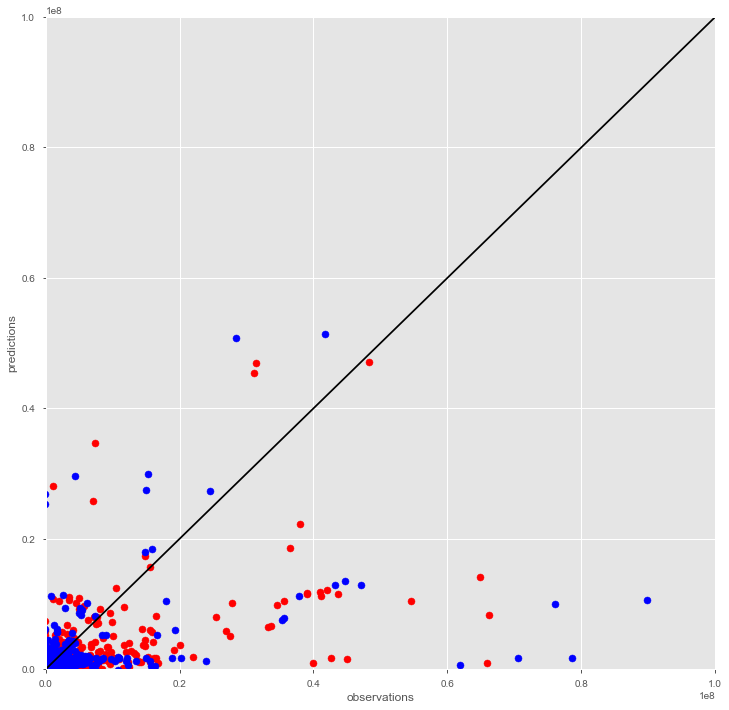

In [140]:
x = np.linspace(-100000000,100000000,100000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, aml.predict(training_frame).as_data_frame()['predict'].values, c='red')
plt.scatter(y_test, aml.predict(testing_frame).as_data_frame()['predict'].values, c='blue')
#plt.scatter(train_df['voyage_duration'], train_df['eta_diff'], c='green')
plt.plot(x,x,c='black')
plt.xlim([-5,100000000])
plt.ylim([-5,100000000])
plt.xlabel('observations')
plt.ylabel('predictions')


In [141]:
aml.leader

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_104950_model_1

Status of Neuron Layers: predicting OA_Difference, regression, gaussian distribution, Quadratic loss, 45,051 weights/biases, 587.7 KB, 3,814,279 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,899,Input,15.0,,,,,,,,,
,2,50,RectifierDropout,10.0,0.0,0.0,0.3438267,0.3566554,0.0,-0.0231251,0.1862196,-0.8394995,1.3404660
,3,1,Linear,,0.0,0.0,0.0017254,0.0062648,0.0,-0.0315148,0.1126776,0.7294513,0.0000000




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 2521145433778.89
RMSE: 1587811.5233801808
MAE: 925074.3007110745
RMSLE: NaN
Mean Residual Deviance: 2521145433778.89

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 5051273221336.324
RMSE: 2247503.775600015
MAE: 105264.0685874478
RMSLE: NaN
Mean Residual Deviance: 5051273221336.324
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,172808.73,108336.47,84719.7,478033.3,92215.88,86803.0,122271.79
mean_residual_deviance,5151686900000.0000000,2463525500000.0000000,1335612150000.0000000,10459287700000.0000000,6311216900000.0000000,1267061230000.0000000,6385257400000.0000000
mse,5151686900000.0000000,2463525500000.0000000,1335612150000.0000000,10459287700000.0000000,6311216900000.0000000,1267061230000.0000000,6385257400000.0000000
r2,0.0452700,0.0192842,0.0266646,0.0425693,0.0635405,0.0078847,0.0856911
residual_deviance,5151686900000.0000000,2463525500000.0000000,1335612150000.0000000,10459287700000.0000000,6311216900000.0000000,1267061230000.0000000,6385257400000.0000000
rmse,2110905.5,589815.7,1155686.9,3234082.2,2512213.5,1125638.1,2526906.8
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
,2019-09-03 11:12:38,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan
,2019-09-03 11:12:39,4 min 55.884 sec,42687 obs/sec,0.3553087,1,38163.0,1086859.9589824,1181264570439.2133789,149282.1169645,-0.0370234
,2019-09-03 11:12:44,5 min 1.250 sec,50305 obs/sec,2.8415481,8,305205.0,1114789.0887090,1242754712304.6879883,92903.9836301,-0.0910051
,2019-09-03 11:12:50,5 min 6.885 sec,52942 obs/sec,5.6798004,16,610056.0,1171698.9568419,1372878445464.4255371,95012.2262898,-0.2052398
,2019-09-03 11:12:55,5 min 11.921 sec,53548 obs/sec,8.1688329,23,877398.0,1305015.3864539,1703065158881.3532715,85143.0029731,-0.4951083
,2019-09-03 11:13:00,5 min 17.141 sec,53392 obs/sec,10.6563664,30,1144579.0,1194959.1216412,1427927302393.4191895,83458.8669474,-0.2535668
,2019-09-03 11:13:06,5 min 22.686 sec,54072 obs/sec,13.4945069,38,1449418.0,1201219.9999967,1442929488392.1032715,83260.6461163,-0.2667371
,2019-09-03 11:13:11,5 min 27.993 sec,53759 obs/sec,15.9810349,45,1716491.0,1097878.3837944,1205336945603.0825195,131200.5859002,-0.0581564
,2019-09-03 11:13:16,5 min 33.144 sec,53754 obs/sec,18.4698626,52,1983811.0,1218112.5071543,1483798080085.8261719,118076.0770788,-0.3026153
,2019-09-03 11:13:21,5 min 38.209 sec,53852 obs/sec,20.9564185,59,2250887.0,1065985.6480166,1136325401777.2780762,85633.9111977,0.0024284


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Revenue or Expenditure.Expenditures,1.0,1.0,0.0136641
GL Category Description.500 - Personnel Services,0.8597383,0.8597383,0.0117476
GL Category Description.510 - Supplies,0.8143474,0.8143474,0.0111274
GL Category Description.520 - Other Services and Charges,0.7827973,0.7827973,0.0106962
Original Budget,0.5902509,0.5902509,0.0080653
---,---,---,---
GL Description.500210 - Pay for Performance Plan - Municipal,0.0363903,0.0363903,0.0004972
GL Description.520139 - Motor Pool Charges,0.0344102,0.0344102,0.0004702
GL Description.missing(NA),0.0,0.0,0.0
GL Category Description.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [ ]:
#10:49am 9/3

In [ ]:
h2o.cluster().shutdown()

In [ ]:
a = np.random.random(50)
print(a)
print(a[::3])

In [ ]:
df['OA_Difference'].describe()

In [ ]:
sns.distplot(a)

In [ ]:
df['OA_Difference'].shape

In [ ]:
len(df.loc[(df['OA_Difference']<=1.0) & (df['OA_Difference']>=-1.0)]['OA_Difference'])

In [ ]:
df['OA_Difference'].value_counts()

In [ ]:
OA_Diff = df['OA_Difference']

In [ ]:
#Seaborn distplot of room 2170 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(list(OA_Diff),bins=10, ax=ax)

ax.set_xlim(-8e7,8e7)
#ax.set(xticks=[-40000000, -20000000,0, 20000000, 40000000])

# ax.set_title("32 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
# ax.set_ylabel("Frequency")
# ax.set_xlabel("Percent A's Given")

In [ ]:
sns.distplot(list(OA_Diff))

In [ ]:
df['OA_Difference'].max()

In [ ]:
df['OA_Difference'].std()

In [ ]:
df['OA_Difference'].min()

In [ ]:
df['Original Budget'].std()

In [ ]:
df['Original Budget'].min()

In [ ]:
df.loc[df['Original Budget']==df['Original Budget'].min()]

In [ ]:
(df.loc[df['Original Budget']>0]['OA_Difference'].values).std()

In [ ]:
original_df = df.copy(deep=True)

In [ ]:
df = df.loc[df['Original Budget']>0]

In [ ]:
#plt.hist(df['OA_Difference'].values)

In [ ]:
%%capture --no-display
pandas_profiling.ProfileReport(df)

In [ ]:
plt.hist(df['OA_Difference'].values)